# The Pedestrian Detection Pipeline
In this notebook the tools created previously are used to detect pedestrians in a given input image. 
Therfore the following steps must be performed:
1. Get the input picture
2. Use sliding window and image pyramids to extract regions of interest 
3. Classify regions of interest with resnet50 adapted for pedestrian detection
4. Apply non maximum surperssion to only dispaly best fitting bounding boxes




In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from torchvision import datasets, transforms, models
import os
import time
import numpy as np
from pathlib import Path
from imutils.object_detection import non_max_suppression

#### Load resnet50 trained for pedestrian detection:

In [2]:
# get model from library
model = models.resnet50(pretrained=True)
# remove original output layer and replace it with 2 dimensinal layer 
number_input_features  = model.fc.in_features
num_classes =2
model.fc = nn.Linear(number_input_features, num_classes)
# load model trained in second notebook
model.load_state_dict(torch.load('./saved_models/pedestrianClassifier5Epochsiou045-2020-10-20-11-15-47.pt'))


<All keys matched successfully>

<class 'PIL.Image.Image'>


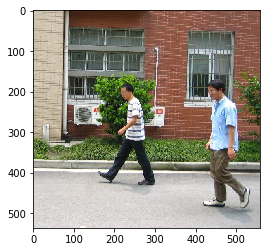

In [3]:
# get an image to test
from DataClass import PennFudanDataset
root = './data/PennFudanPed'
data = PennFudanDataset(root, transforms=None)

# display the selected image
sample_image = data[0]['img']
plt.imshow(sample_image)
print(type(sample_image))


In [4]:
from helpers import sliding_window, image_pyramid, display_bounding_box

def prediction_transforms(roi):
    
    pred_transform = transforms.Compose([        
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    roi = pred_transform(roi)
        
    return roi

def detect_pedestrian(image, model,slidingWindow_parameters={'height':int(275),'width':int(100),'step_w':50,'step_h':50},ImagePyramid_parameters=(224,224)):
       
    listOfBoundningBoxes = []
    listOfProbs =[]
    
    locs = []
    rois = []
    
    ImgWidth,imgHeight = image.size
    
    # initialize image pyramid
    imgPyramide = image_pyramid(image,minSize=ImagePyramid_parameters)
    
    for img in imgPyramide:
        
        # get current scale to rescale roi later 
        scale = ImgWidth/float(img.size[0])
        
        # create sliding window generator 
        sliding = sliding_window(img,
                                 window_size=(slidingWindow_parameters['width'],slidingWindow_parameters['height']),
                                 step_w=int(slidingWindow_parameters['step_w']/scale),
                                 step_h=int(slidingWindow_parameters['step_h']/scale))  
        
        
        # initialize sliding window
        for slide_img in sliding:
            
            windowBox = slide_img[0]
            windowBox= tuple(int(x*scale) for x in windowBox)
            
            locs.append(windowBox)
       
            
            # prepare region of interest for input into the classifier
            roi =slide_img[1].resize((224,int(224*2.5)))
            roi = prediction_transforms(roi)
            rois.append(roi)    
    
    
    # create timer to track time for this ....
    
    
    # classify the roi
    model.eval()
    with torch.no_grad():
        rois =torch.stack(rois, dim=0)
        
         
        
        predLoader = torch.utils.data.DataLoader(rois,batch_size=8)
        sm = torch.nn.Softmax(dim=1)
        outputs = []
        
        # split rois to prevent memory overload
        for inputs in predLoader:
            # use model to classify rois
            outputs.append(model(inputs))
        outputs =torch.cat(outputs, dim=0)
        
        _, preds = torch.max(outputs.data, 1)
        probs= sm(outputs)
        
        
        # get list of indexes that conatain a pedestrian
        indexes = preds.numpy().nonzero()
       
        for index in indexes[0]:
            print(f"Detected pedestrian at index {index}.")
            listOfBoundningBoxes.append(locs[index])
            listOfProbs.append(probs[index][1])
    

        
    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[xmin, ymin, xmax, ymax] for (xmin, ymin, xmax, ymax) in listOfBoundningBoxes])
    picks = non_max_suppression(rects, probs=listOfProbs, overlapThresh=0.1)
        
    return picks
                    

## Examples


Detected pedestrian at index 23.
Detected pedestrian at index 24.
Detected pedestrian at index 29.
Detected pedestrian at index 33.
Detected pedestrian at index 34.
Detected pedestrian at index 35.
Detected pedestrian at index 38.
Detected pedestrian at index 39.
Detected pedestrian at index 43.
Detected pedestrian at index 44.
Detected pedestrian at index 47.
Detected pedestrian at index 48.
Detected pedestrian at index 49.
Detected pedestrian at index 54.
Detected pedestrian at index 58.
Detected pedestrian at index 59.
Detected pedestrian at index 62.
Detected pedestrian at index 63.
Detected pedestrian at index 64.
Detected pedestrian at index 71.
Detected pedestrian at index 72.
Detected pedestrian at index 73.
Detected pedestrian at index 76.
Detected pedestrian at index 77.
Detected pedestrian at index 80.
Detected pedestrian at index 81.
Detected pedestrian at index 82.
Detected pedestrian at index 84.
Detected pedestrian at index 85.
Detected pedestrian at index 86.
CPU times:

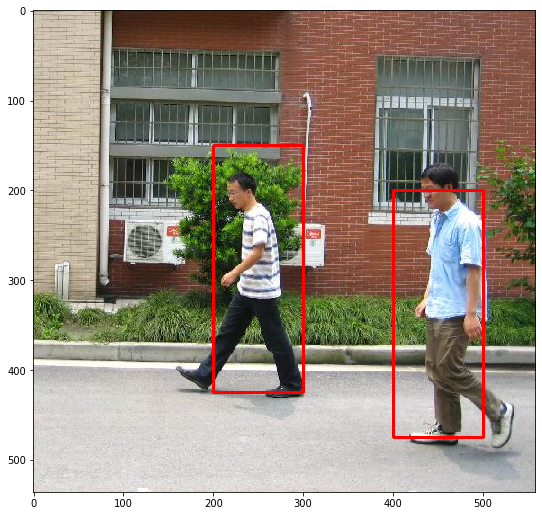

In [5]:
%%time
sample_image = data[0]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 14.
Detected pedestrian at index 15.
Detected pedestrian at index 21.
Detected pedestrian at index 22.
Detected pedestrian at index 23.
Detected pedestrian at index 28.
Detected pedestrian at index 29.
Detected pedestrian at index 30.
CPU times: user 43.7 s, sys: 4.69 s, total: 48.4 s
Wall time: 25.5 s


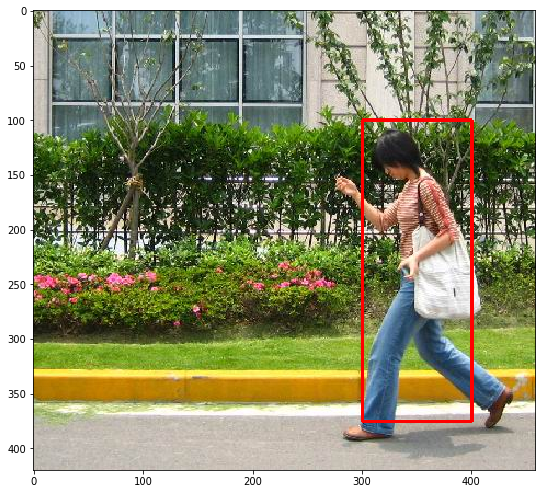

In [6]:
%%time
sample_image = data[10]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 22.
Detected pedestrian at index 23.
Detected pedestrian at index 30.
Detected pedestrian at index 31.
Detected pedestrian at index 37.
Detected pedestrian at index 38.
CPU times: user 2min 11s, sys: 11.3 s, total: 2min 22s
Wall time: 1min 23s


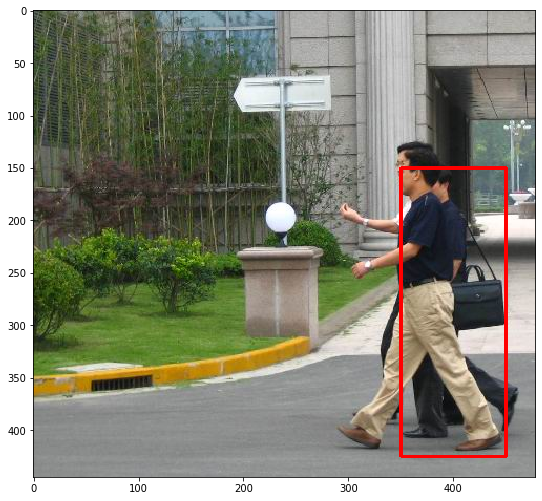

In [7]:
%%time
sample_image = data[2]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 0.
Detected pedestrian at index 3.
Detected pedestrian at index 4.
Detected pedestrian at index 5.
Detected pedestrian at index 9.
Detected pedestrian at index 10.
Detected pedestrian at index 11.
Detected pedestrian at index 15.
Detected pedestrian at index 16.
CPU times: user 1min 9s, sys: 5.2 s, total: 1min 14s
Wall time: 40.1 s


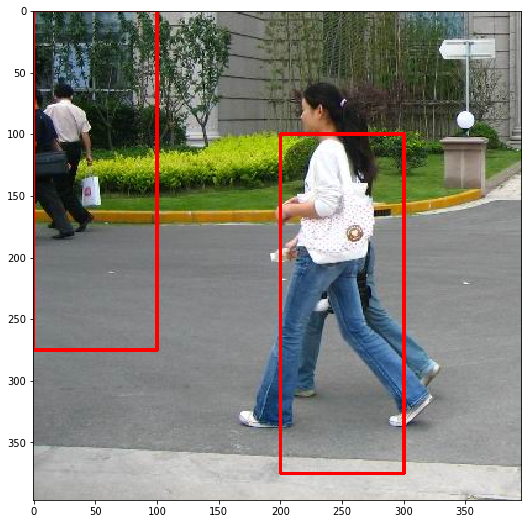

In [8]:
%%time
sample_image = data[3]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 3.
Detected pedestrian at index 4.
Detected pedestrian at index 8.
Detected pedestrian at index 9.
CPU times: user 43.5 s, sys: 2.93 s, total: 46.4 s
Wall time: 24.7 s


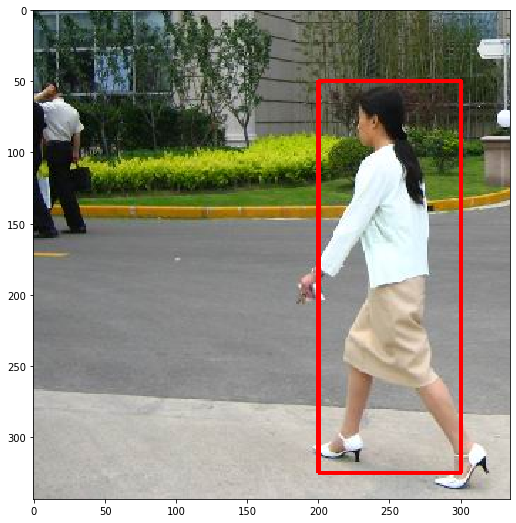

In [9]:
%%time
sample_image = data[4]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 17.
Detected pedestrian at index 21.
Detected pedestrian at index 26.
Detected pedestrian at index 27.
Detected pedestrian at index 30.
Detected pedestrian at index 31.
Detected pedestrian at index 36.
Detected pedestrian at index 37.
Detected pedestrian at index 38.
Detected pedestrian at index 40.
Detected pedestrian at index 46.
Detected pedestrian at index 47.
Detected pedestrian at index 56.
Detected pedestrian at index 65.
Detected pedestrian at index 66.
CPU times: user 54.7 s, sys: 5.81 s, total: 1min
Wall time: 31.5 s


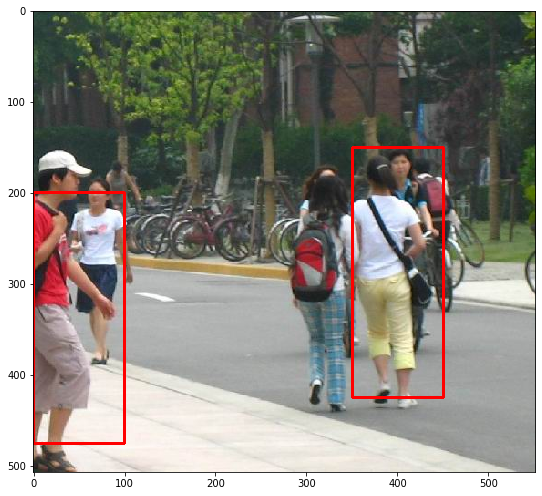

In [10]:
%%time
sample_image = data[40]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 2.
Detected pedestrian at index 3.
Detected pedestrian at index 4.
Detected pedestrian at index 5.
Detected pedestrian at index 6.
Detected pedestrian at index 7.
Detected pedestrian at index 11.
Detected pedestrian at index 12.
Detected pedestrian at index 13.
Detected pedestrian at index 14.
Detected pedestrian at index 15.
Detected pedestrian at index 16.
Detected pedestrian at index 21.
Detected pedestrian at index 22.
Detected pedestrian at index 23.
Detected pedestrian at index 24.
Detected pedestrian at index 25.
CPU times: user 13.6 s, sys: 2.16 s, total: 15.8 s
Wall time: 8.06 s


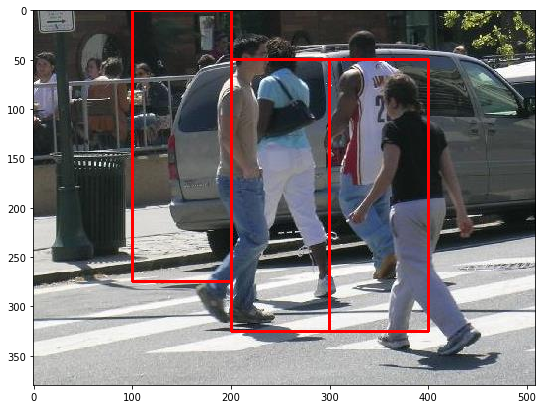

In [14]:
%%time
sample_image = data[131]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

#imports 
import imutils
import os
from PIL import Image
import numpy as np
import cv2
import PIL
from matplotlib import pyplot as plt


def display_bounding_box(image,box_coordinates, display=True, resize=(0,0),cropBox=None):
    '''
    Display_bounding_box is a function that draws the corresponding bounding boxes into the images
 
    params: 
             image: Image file or patht to the image file
             box_coordinates: Coordinadtes of the bounding boxes inside the image (np-array)
             display: Whether the image and the corrsponding bounding box should be displayed
             resize: Tuple values to resize image to given input width
    '''
    # if path is provided get image, else image is already given
    if isinstance(image, str):
        image = cv2.imread(image)
        # switch red and blue color channels 
        # -> by default OpenCV assumes BLUE comes first, not RED as in many images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     
    elif